In [ ]:
%matplotlib inline
import numpy as np
import pandas as pd
import tensorflow as tf
from matplotlib import pyplot as plt
from tensorflow.contrib import learn
from sklearn.metrics import mean_squared_error
from lstm import generate_data, lstm_model
from tensorflow.python.framework import dtypes
from tensorflow.contrib import learn

In [ ]:
LOG_DIR = './ops_logs/2_point_model'
TIMESTEPS = 5
RNN_LAYERS = [{'num_units': 5}, {'num_units': 2}]
DENSE_LAYERS = None
TRAINING_STEPS = 10000
PRINT_STEPS = TRAINING_STEPS / 10
BATCH_SIZE = 100

In [ ]:
regressor = learn.Estimator(model_fn=lstm_model(TIMESTEPS, RNN_LAYERS, DENSE_LAYERS), model_dir=LOG_DIR)

In [ ]:
X, y = generate_data(pd.read_csv('heatmap_data.csv'), TIMESTEPS, seperate=False)
# create a lstm instance and validation monitor
validation_monitor = learn.monitors.ValidationMonitor(X['val'], y['val'],every_n_steps=PRINT_STEPS,
                                                                                          early_stopping_rounds=1000)
regressor.fit(X['train'], y['train'], monitors=[validation_monitor], batch_size=BATCH_SIZE, steps=TRAINING_STEPS)

In [ ]:
predicted = regressor.predict(X['test'])
rmse = np.sqrt(((predicted - y['test']) ** 2).mean(axis=0))
score = mean_squared_error(predicted, y['test'])
print ("MSE: %f" % score)

In [ ]:
plt.figure(figsize=(20,10))
plt.subplot(211)
plt.plot(predicted[:,0],label='predicted 0')
plt.plot(y['test'][:,0],label='true 0')
plt.legend()
plt.subplot(212)
plt.plot(predicted[:,1],label='predicted 15')
plt.plot(y['test'][:,1],label='true 15')
plt.legend()
plt.show()

# different code down here

In [2]:
import matplotlib.pyplot as plt
%matplotlib inline  
from numpy import array, sin, cos, pi
from random import random
import tensorflow as tf
from tensorflow.python.ops.rnn import *

In [3]:
##Producing Training/Testing inputs+output

#Random initial angles
angle1 = random()
angle2 = random()
 
#The total 2*pi cycle would be divided into 'frequency'
#number of steps
frequency1 = 333
frequency2 = 211
#This defines how many steps ahead we are trying to predict
lag = 40
 
def get_sample():
    """
    Returns a [[sin value, cos value]] input.
    """
    global angle1, angle2
    angle1 += 2*pi/float(frequency1)
    angle2 += 2*pi/float(frequency2)
    angle1 %= 2*pi
    angle2 %= 2*pi
    return array([array([
        5 + 5*sin(angle1) + 10*cos(angle2)**2,
        7 + 7*sin(angle2)**3 + 14*cos(angle1)])])
 
    
sliding_window = []
 
for i in range(lag - 1):
    sliding_window.append(get_sample())
 
 
def get_pair():
    """
    Returns an (current, later) pair, where 'later' is 'lag'
    steps ahead of the 'current' on the wave(s) as defined by the
    frequency.
    """
 
    global sliding_window
    sliding_window.append(get_sample())
    input_value = sliding_window[0]
    output_value = sliding_window[-1]
    sliding_window = sliding_window[1:]
    return input_value, output_value

In [4]:
actual_input1 = []
actual_input2 = []
actual_output1 = []
actual_output2 = []
x_axis = []

for i in range(2000):
    input_v, output_v = get_pair()
    actual_input1.append(input_v[0][0])
    actual_input2.append(input_v[0][1])
    actual_output1.append(output_v[0][0])
    actual_output2.append(output_v[0][1])
    x_axis.append(i)

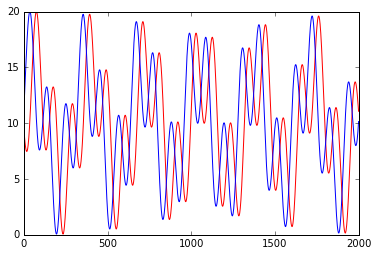

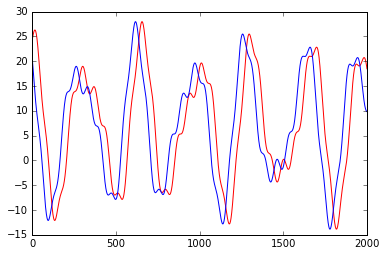

In [5]:
plt.plot(x_axis, actual_input1, 'r-', x_axis, actual_output1, 'b-')
plt.show()
plt.plot(x_axis, actual_input2, 'r-', x_axis, actual_output2, 'b-')
plt.show()

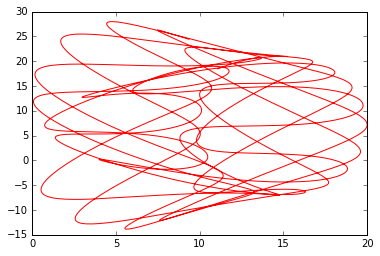

In [6]:
#Plot X against Y
plt.plot(actual_input1, actual_input2, 'r-')
plt.show()

In [8]:
##############################
#Input Params
input_dim = 2
 
#To maintain state
last_value = array([0 for i in range(input_dim)])
last_derivative = array([0 for i in range(input_dim)])
 
def get_total_input_output():
    """
    Returns the overall Input and Output as required by the model.
    The input is a concatenation of the wave values, their first and
    second derivatives.
    """
    global last_value, last_derivative
    raw_i, raw_o = get_pair()
    raw_i = raw_i[0]
    l1 = list(raw_i)
    derivative = raw_i - last_value
    l2 = list(derivative)
    last_value = raw_i
    l3 = list(derivative - last_derivative)
    last_derivative = derivative
    return array([l1 + l2 + l3]), raw_o

In [9]:
#Input Params
input_dim = 2
 
##The Input Layer as a Placeholder
#Since we will provide data sequentially, the 'batch size'
#is 1.
input_layer = tf.placeholder(tf.float32, [1, input_dim*3])

In [10]:
cell_type = 4

In [11]:
##Create outputs
output_W1 = tf.Variable(tf.truncated_normal([input_dim*3, input_dim]))
output_b1 = tf.Variable(tf.zeros([input_dim]))

In [12]:
if cell_type == 1:
    lstm_layer1 = rnn_cell.BasicRNNCell(input_dim*3)
    lstm_state1 = tf.Variable(tf.zeros([1, lstm_layer1.state_size]))
    lstm_output1, lstm_state_output1 = lstm_layer1(input_layer, lstm_state1, scope="BasicRNN")
    lstm_update_op1 = lstm_state1.assign(lstm_state_output1)
    final_output = tf.matmul(lstm_output1, output_W1) + output_b1
if cell_type == 2:
    lstm_layer2 = rnn_cell.GRUCell(input_dim*3)
    lstm_state2 = tf.Variable(tf.zeros([1, lstm_layer2.state_size]))
    lstm_output2, lstm_state_output2 = lstm_layer2(input_layer, lstm_state2, scope="GRUCell")
    lstm_update_op2 = lstm_state2.assign(lstm_state_output2)
    final_output = tf.matmul(lstm_output2, output_W1) + output_b1
if cell_type == 3:
    lstm_layer3 = rnn_cell.BasicLSTMCell(input_dim*3)
    lstm_state3 = tf.Variable(tf.zeros([1, lstm_layer3.state_size]))
    lstm_output3, lstm_state_output3 = lstm_layer3(input_layer, lstm_state3, scope="BasicLSTM")
    lstm_update_op3 = lstm_state3.assign(lstm_state_output3)
    final_output = tf.matmul(lstm_output3, output_W1) + output_b1
if cell_type == 4:
    lstm_layer4 = rnn_cell.BasicLSTMCell(input_dim*3)
    lstm_layer4 = rnn_cell.MultiRNNCell([lstm_layer4]*2)
    lstm_layer4 = rnn_cell.DropoutWrapper(lstm_layer4,output_keep_prob=0.8)
    lstm_state4 = tf.Variable(tf.zeros([1, lstm_layer4.state_size]))
    lstm_output4, lstm_state_output4 = lstm_layer4(input_layer, lstm_state4, scope="LSTM-2")
    lstm_update_op4 = lstm_state4.assign(lstm_state_output4)
    final_output = tf.matmul(lstm_output4, output_W1) + output_b1

In [13]:
##Input for correct output (for training)
correct_output = tf.placeholder(tf.float32, [1, input_dim])

##Calculate the Sum-of-Squares Error
error = tf.pow(tf.sub(final_output, correct_output), 2)

##The Optimizer
#Adam works best
train_step = tf.train.AdamOptimizer(0.0006).minimize(error)
w_hist = tf.histogram_summary('weights', output_W1)
b_hist = tf.histogram_summary('biases', output_b1)
y_hist = tf.histogram_summary('y', final_output)

##Session
sess = tf.Session()
#Initialize all Variables
merged = tf.merge_summary([w_hist,b_hist,y_hist])
tf.train.write_graph(sess.graph_def,'/tmp/tensor','graph.txt')
writer = tf.train.SummaryWriter('/tmp/tensor/',sess.graph_def)
sess.run(tf.initialize_all_variables())

In [ ]:
##Training
 
actual_output1 = []
actual_output2 = []
network_output1 = []
network_output2 = []
x_axis = []
 
for i in range(50000):
    input_v, output_v = get_total_input_output()
    if cell_type == 1:
        _, _, network_output, merge = sess.run([lstm_update_op1,
                                     train_step,
                                     final_output,merged],
                                    feed_dict = {
                                        input_layer: input_v,
                                        correct_output: output_v})
    if cell_type == 2:
        _, _, network_output, merge = sess.run([lstm_update_op2,
                                     train_step,
                                     final_output,merged],
                                    feed_dict = {
                                        input_layer: input_v,
                                        correct_output: output_v})
    if cell_type == 3:
        _, _, network_output, merge = sess.run([lstm_update_op3,
                                     train_step,
                                     final_output,merged],
                                    feed_dict = {
                                        input_layer: input_v,
                                        correct_output: output_v})
    if cell_type == 4:
        _, _, network_output, merge = sess.run([lstm_update_op4,
                                     train_step,
                                     final_output,merged],
                                    feed_dict = {
                                        input_layer: input_v,
                                        correct_output: output_v})
    actual_output1.append(output_v[0][0])
    actual_output2.append(output_v[0][1])
    network_output1.append(network_output[0][0])
    network_output2.append(network_output[0][1])
    x_axis.append(i)
    writer.add_summary(merge, i)

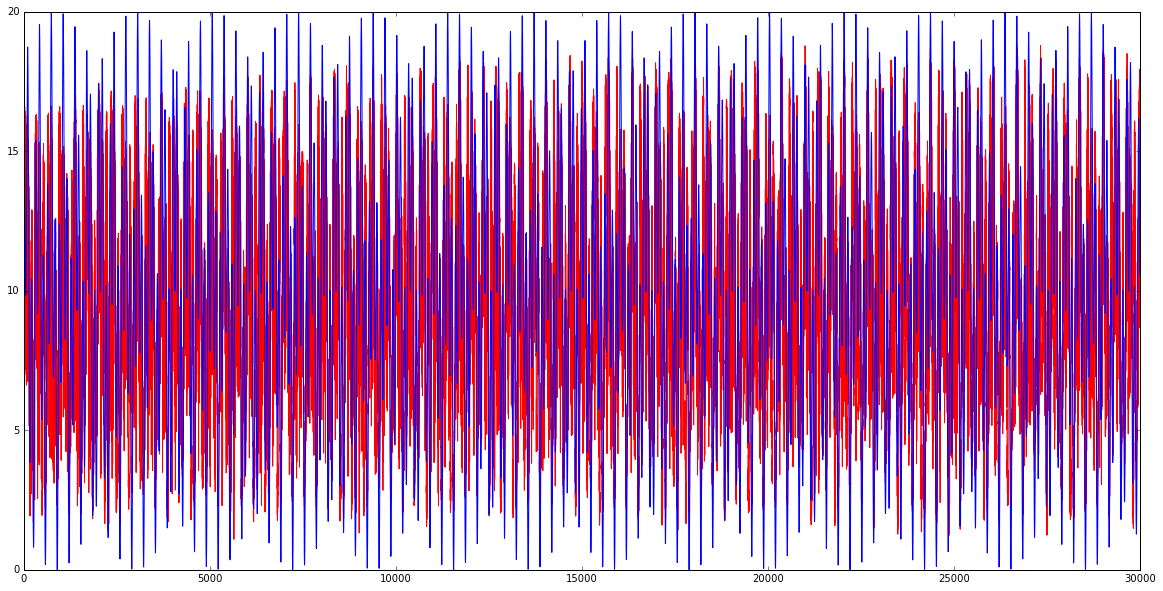

In [51]:
plt.figure(figsize=(20,10))
plt.plot(x_axis, network_output1, 'r-', x_axis, actual_output1, 'b-')
plt.show()

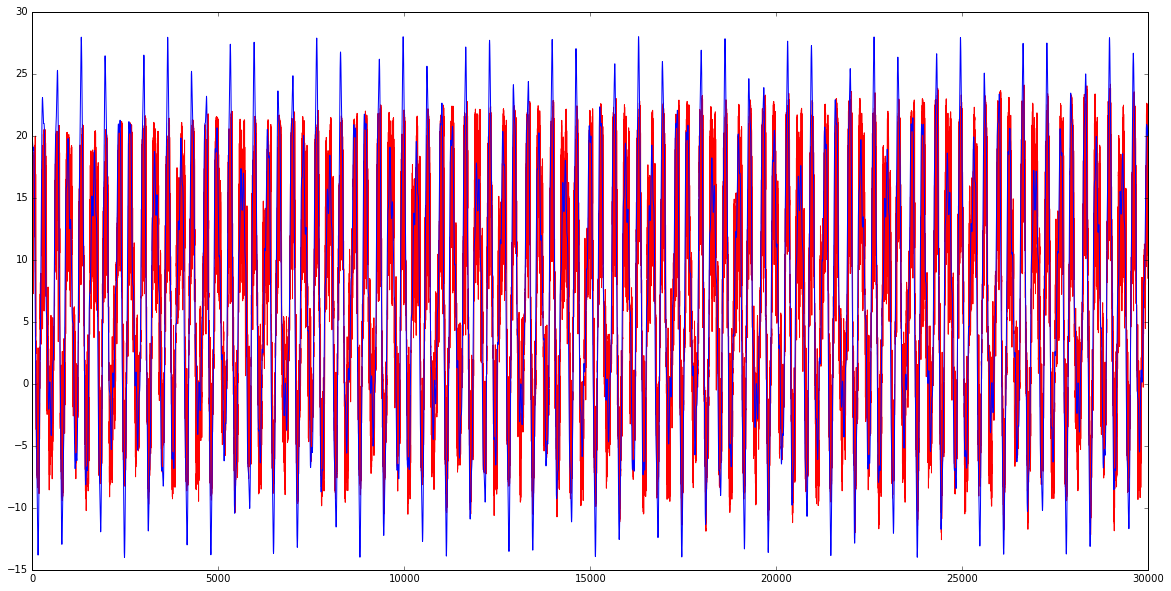

In [52]:
plt.figure(figsize=(20,10))
plt.plot(x_axis, network_output2, 'r-', x_axis, actual_output2, 'b-')
plt.show()

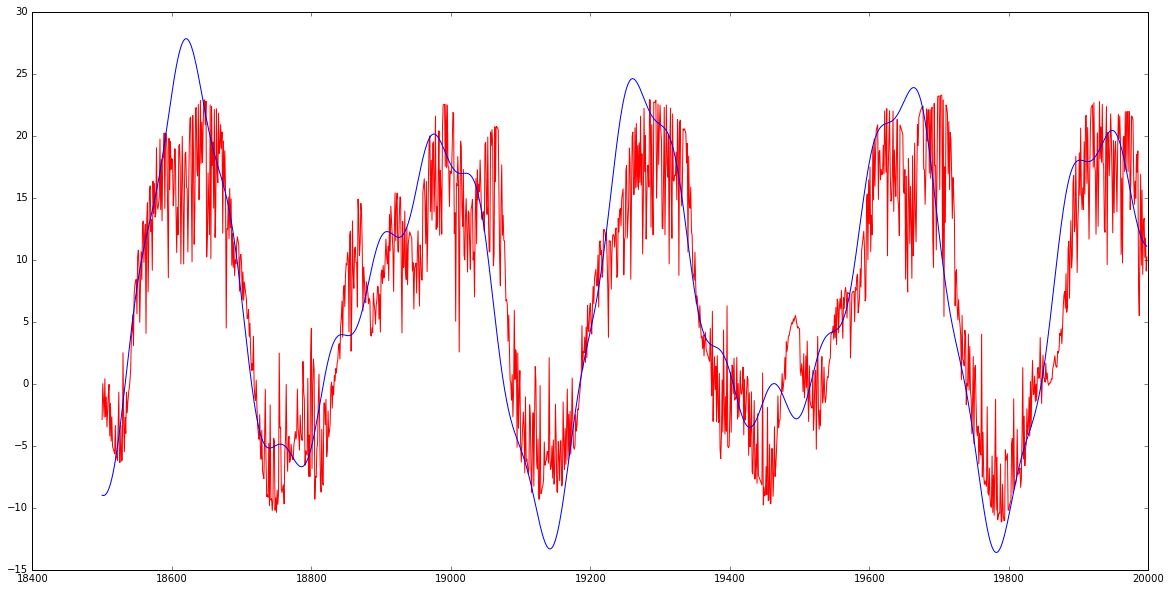

In [53]:
plt.figure(figsize=(20,10))
plt.plot(x_axis[18500:19999], network_output2[18500:19999], 'r-', x_axis[18500:19999], actual_output2[18500:19999], 'b-')
plt.show()

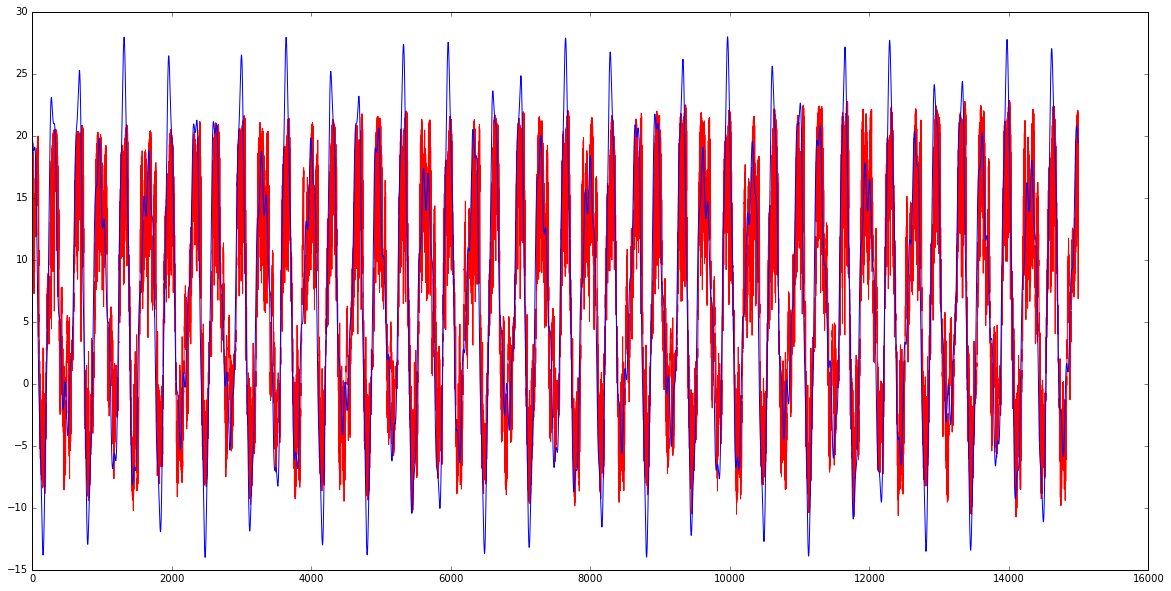

In [54]:
plt.figure(figsize=(20,10))
plt.plot(x_axis[0:15000], network_output2[0:15000], 'r-', x_axis[0:15000], actual_output2[0:15000], 'b-')
plt.show()

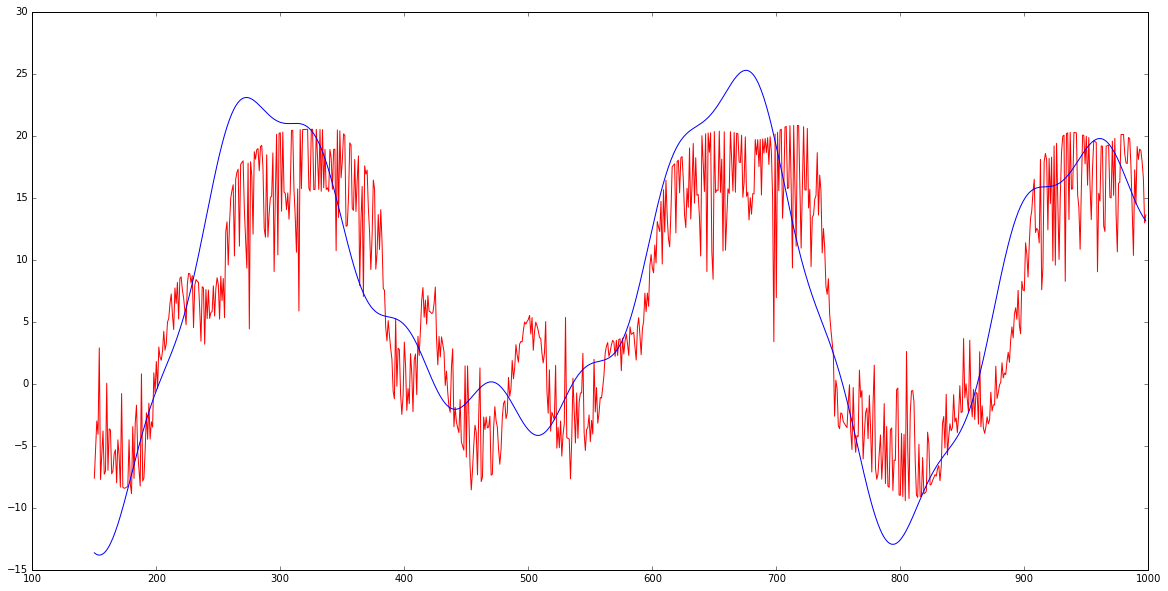

In [55]:
plt.figure(figsize=(20,10))
plt.plot(x_axis[150:999], network_output2[150:999], 'r-', x_axis[150:999], actual_output2[150:999], 'b-')
plt.show()

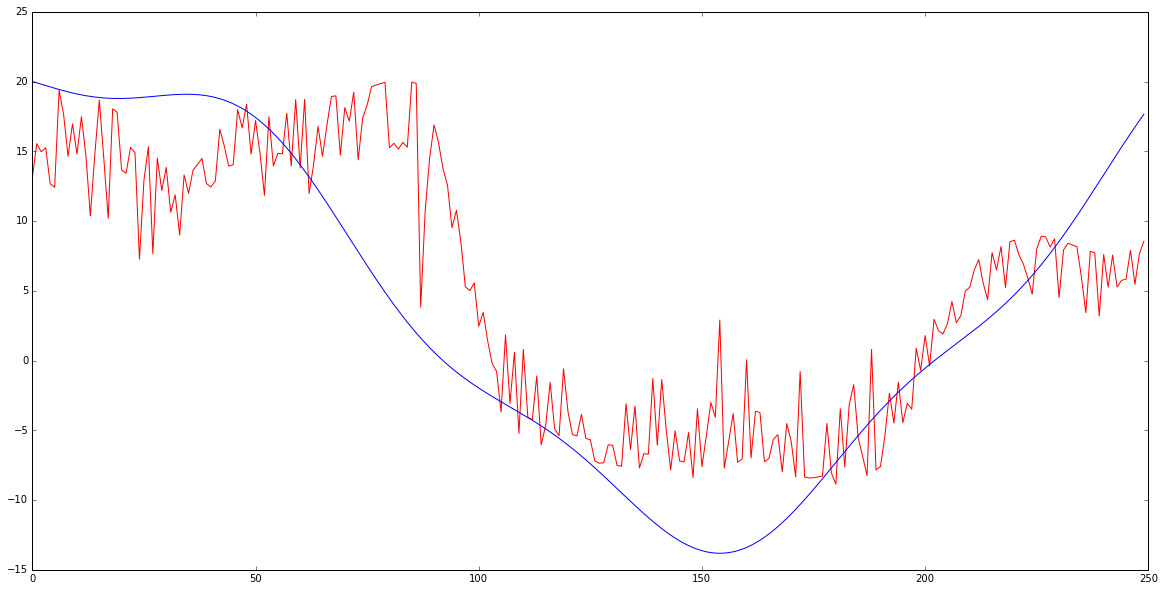

In [58]:
plt.figure(figsize=(20,10))
plt.plot(x_axis[0:250], network_output2[0:250], 'r-', x_axis[0:250], actual_output2[0:250], 'b-')
plt.show()

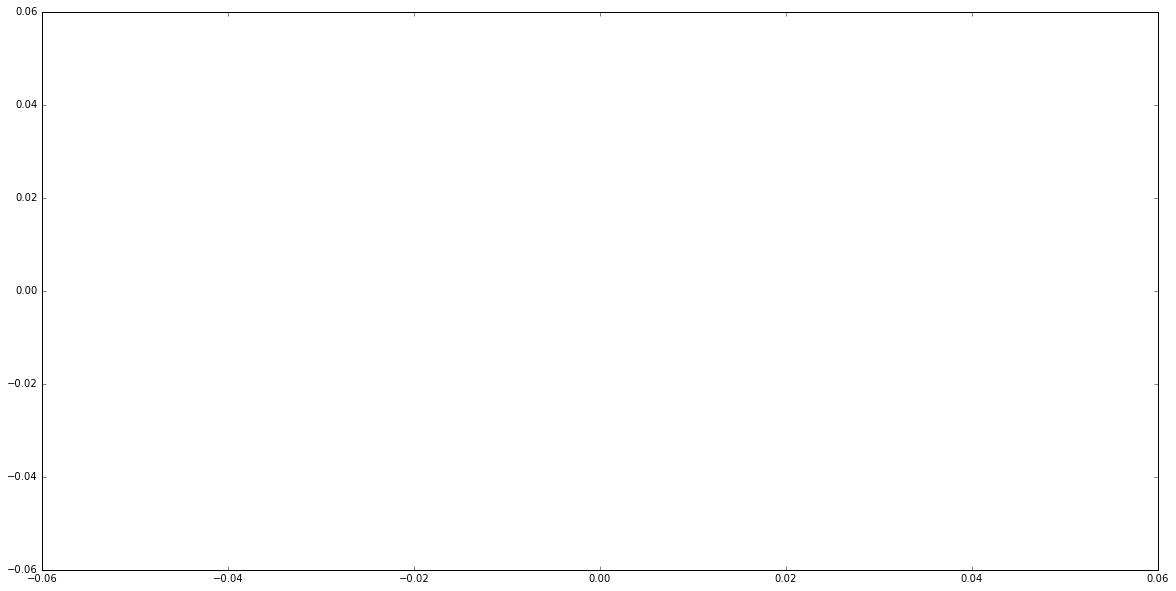

In [59]:
plt.figure(figsize=(20,10))
plt.plot(x_axis[78500:79999], network_output2[78500:79999], 'r-', x_axis[78500:79999], actual_output2[78500:79999], 'b-')
plt.show()

In [60]:
##Testing
 
for i in range(200):
    get_total_input_output()
#Flush LSTM state
###NEED TO FIX THIS TO RUN MODEL CHOSEN ABOVE###
sess.run(lstm_state4.assign(tf.zeros([1, lstm_layer4.state_size])))

array([[ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.]], dtype=float32)

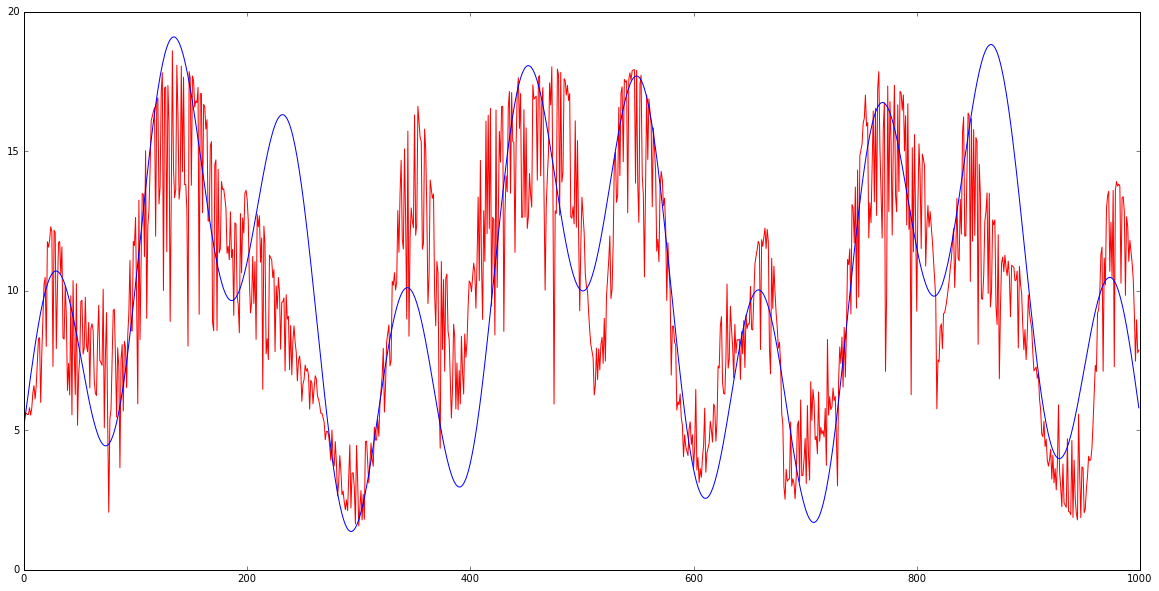

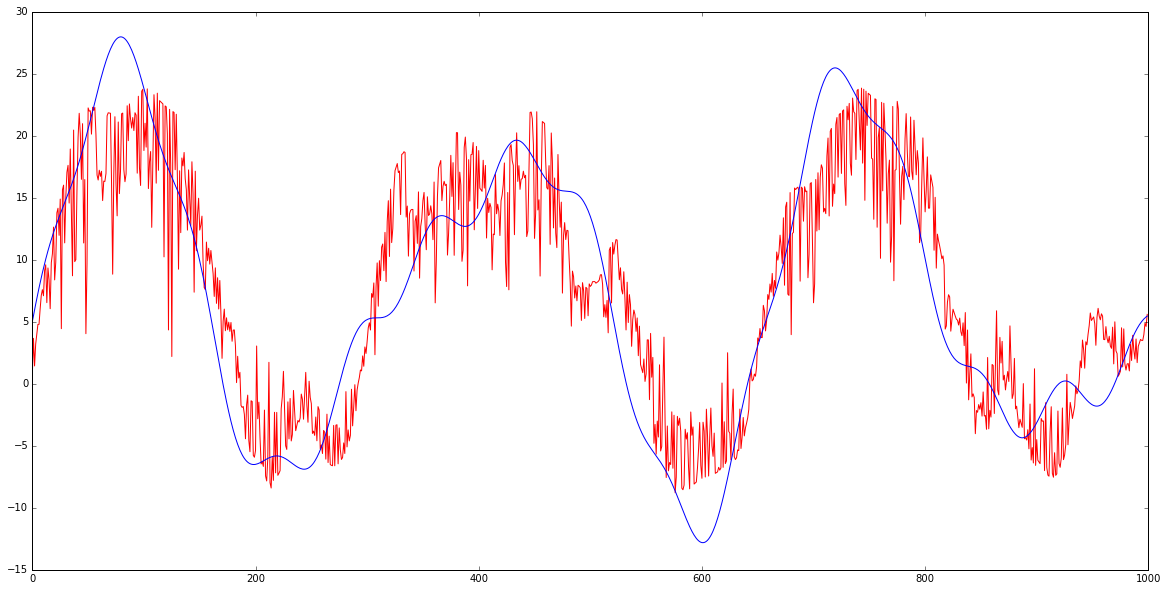

In [62]:
test_actual_output1 = []
test_actual_output2 = []
test_network_output1 = []
test_network_output2 = []
test_x_axis = []
 
for i in range(1000):
    input_v, output_v = get_total_input_output()
    _, network_output = sess.run([lstm_update_op4,
                                  final_output],
                                 feed_dict = {
                                     input_layer: input_v,
                                     correct_output: output_v})
 
    test_actual_output1.append(output_v[0][0])
    test_actual_output2.append(output_v[0][1])
    test_network_output1.append(network_output[0][0])
    test_network_output2.append(network_output[0][1])
    test_x_axis.append(i)

import matplotlib.pyplot as plt
plt.figure(figsize=(20,10))
plt.plot(test_x_axis, test_network_output1, 'r-', test_x_axis, test_actual_output1, 'b-')
plt.show()
plt.figure(figsize=(20,10))
plt.plot(test_x_axis, test_network_output2, 'r-', test_x_axis, test_actual_output2, 'b-')
plt.show()